In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trillsson/tensorflow2/1/1/saved_model.pb
/kaggle/input/trillsson/tensorflow2/1/1/keras_metadata.pb
/kaggle/input/trillsson/tensorflow2/1/1/variables/variables.index
/kaggle/input/trillsson/tensorflow2/1/1/variables/variables.data-00000-of-00001


In [2]:
# Import primary library dependencies
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Import secondary library dependencies
from pathlib import Path
from scipy.io import wavfile

# Generate warnings
import os
import warnings
import requests
warnings.filterwarnings('ignore')
print(f"Tensorflow version: {tf.__version__}")

2025-12-20 09:52:23.008882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766224343.247689      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766224343.311008      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Tensorflow version: 2.18.0


In [3]:
# Install auxiliary packages
import subprocess
import sys

# Define installation functions
def install(package):
    subprocess.check_call([
        sys.executable,
        "-m",
        "pip",
        package,
        "q"
    ])

# Define package installation configurations
try:
    import librosa
except ImportError:
    print("Installing librosa...")
    install('librosa')
    import librosa

In [6]:
# Download the sample audio files
def download_sample_audio():
    """Download the sample audio files for demonstration"""
    # Create a directory for the audio files
    audio_dir = Path('/kaggle/working/audio_samples')
    audio_dir.mkdir(exist_ok=True)

    # Sample the audio file links
    audio_urls = {
        'speech_sample.wav': 'https://freesound.org/data/previews/2/2518_2518-lq.mp3',
        'music_sample.wav': 'https://freesound.org/data/previews/177/177843_33044-lq.mp3',
        'ambient_sound.wav': 'https://freesound.org/data/previews/207/207650_3162775-lq.mp3'
    }
    
    downloaded_files = []

    print("Downloading sample audio files...")

    for filename, url in audio_urls.items():
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                file_path = audio.dir / filename
                with open(file_path, 'wb') as f:
                    f.write(response.content)
                downloaded_files.append(str(file_path))
                print(f"Download completed: {filename}")
        except Exception as e:
            print(f"Download failed {filename}: {e}")

    return downloaded_files

In [7]:
# Load the TRILLsson model
model_path = '/kaggle/input/trillsson/tensorflow2/1/1'
print(f"\nLoading TRILLsson model from: {model_path}")

# Load the saved model
model = tf.saved_model.load(model_path)
print("Model loaded successfully.")

# Print available signatures
print("\nAvailable signatures: ")
for sig in model.signatures:
    print(f" - {sig}")


Loading TRILLsson model from: /kaggle/input/trillsson/tensorflow2/1/1


I0000 00:00:1766224384.933079      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766224384.933682      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model loaded successfully.

Available signatures: 
 - serving_default


In [8]:
# Get the inference function
infer = model.signatures['serving_default']

# Function to extract embeddings
def extract_embeddings(audio, sample_rate=16000):
    """
    Extract TRILLsson embeddings from audio
    """
    # Ensure audio is float32
    audio = tf.constant(audio, dtype=tf.float32)
    
    # Add batch dimension if needed
    if len(audio.shape) == 1:
        audio = tf.expand_dims(audio, 0)
    
    # Run inference
    embeddings = infer(audio)
    
    # Extract the output; key might vary, check model output (Common keys: 'output', 'embeddings', 'default')
    if 'output' in embeddings:
        return embeddings['output'].numpy()
    elif 'embeddings' in embeddings:
        return embeddings['embeddings'].numpy()
    elif 'default' in embeddings:
        return embeddings['default'].numpy()
    else:
        # Return the first output
        key = list(embeddings.keys())[0]
        return embeddings[key].numpy()

In [9]:
# Create synthetic audio samples for demonstration
def create_demo_audio():
    """
    Create synthetic audio samples with different characteristics
    """
    sr = 16000
    duration = 2.0
    t = np.linspace(0, duration, int(sr * duration))
    
    samples = {}

    # Sample 1: Pure tone (440Hz - A4)
    samples['Pure Tone 440Hz'] = np.sin(2 * np.pi * 440 * t)
    
    # Sample 2: Complex tone (multiple harmonics)
    samples['Complex Tone'] = (np.sin(2 * np.pi * 440 * t) + 
                               0.5 * np.sin(2 * np.pi * 880 * t) + 
                               0.25 * np.sin(2 * np.pi * 1320 * t))

    # Sample 3: Chirp (frequency sweep)
    freq_start, freq_end = 200, 1000
    chirp_freq = np.linspace(freq_start, freq_end, len(t))
    samples['Chirp 200-1000Hz'] = np.sin(2 * np.pi * np.cumsum(chirp_freq) / sr)
    
    # Sample 4: White noise
    samples['White Noise'] = np.random.randn(len(t)) * 0.3

    # Sample 5: Pink noise (1/f noise)
    white = np.random.randn(len(t))
    # Simple pink noise approximation
    b = [0.049922035, -0.095993537, 0.050612699, -0.004408786]
    a = [1, -2.494956002, 2.017265875, -0.522189400]
    from scipy import signal
    samples['Pink Noise'] = signal.lfilter(b, a, white) * 0.3
    
    # Sample 6: Sine wave with vibrato
    vibrato_freq = 5  # Hz
    vibrato_depth = 50  # Hz
    freq_modulated = 440 + vibrato_depth * np.sin(2 * np.pi * vibrato_freq * t)
    phase = 2 * np.pi * np.cumsum(freq_modulated) / sr
    samples['Vibrato Tone'] = np.sin(phase)

    # Sample 7: Pulse train
    pulse_freq = 100  # Hz
    samples['Pulse Train'] = signal.square(2 * np.pi * pulse_freq * t)
    
    # Sample 8: AM modulated signal
    carrier_freq = 1000  # Hz
    mod_freq = 10  # Hz
    mod_index = 0.5
    samples['AM Modulated'] = (1 + mod_index * np.sin(2 * np.pi * mod_freq * t)) * np.sin(2 * np.pi * carrier_freq * t)
    
    # Normalize all samples
    for key in samples:
        if np.max(np.abs(samples[key])) > 0:
            samples[key] = samples[key] / np.max(np.abs(samples[key]))
    
    return samples, sr

In [10]:
# Create demo audio samples
print("\nCreating synthetic audio samples...")
audio_samples, sr = create_demo_audio()

# Extract embeddings for each sample
print("\nExtracting embeddings from synthetic samples...")
embeddings_dict = {}
for name, audio in audio_samples.items():
    print(f"Processing: {name}")
    embeddings = extract_embeddings(audio, sr)
    embeddings_dict[name] = embeddings
    print(f"Embedding shape: {embeddings.shape}")


Creating synthetic audio samples...

Extracting embeddings from synthetic samples...
Processing: Pure Tone 440Hz


I0000 00:00:1766224405.305784     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


Embedding shape: (1, 1024)
Processing: Complex Tone
Embedding shape: (1, 1024)
Processing: Chirp 200-1000Hz
Embedding shape: (1, 1024)
Processing: White Noise
Embedding shape: (1, 1024)
Processing: Pink Noise
Embedding shape: (1, 1024)
Processing: Vibrato Tone
Embedding shape: (1, 1024)
Processing: Pulse Train
Embedding shape: (1, 1024)
Processing: AM Modulated
Embedding shape: (1, 1024)



Visualizing audio waveforms...


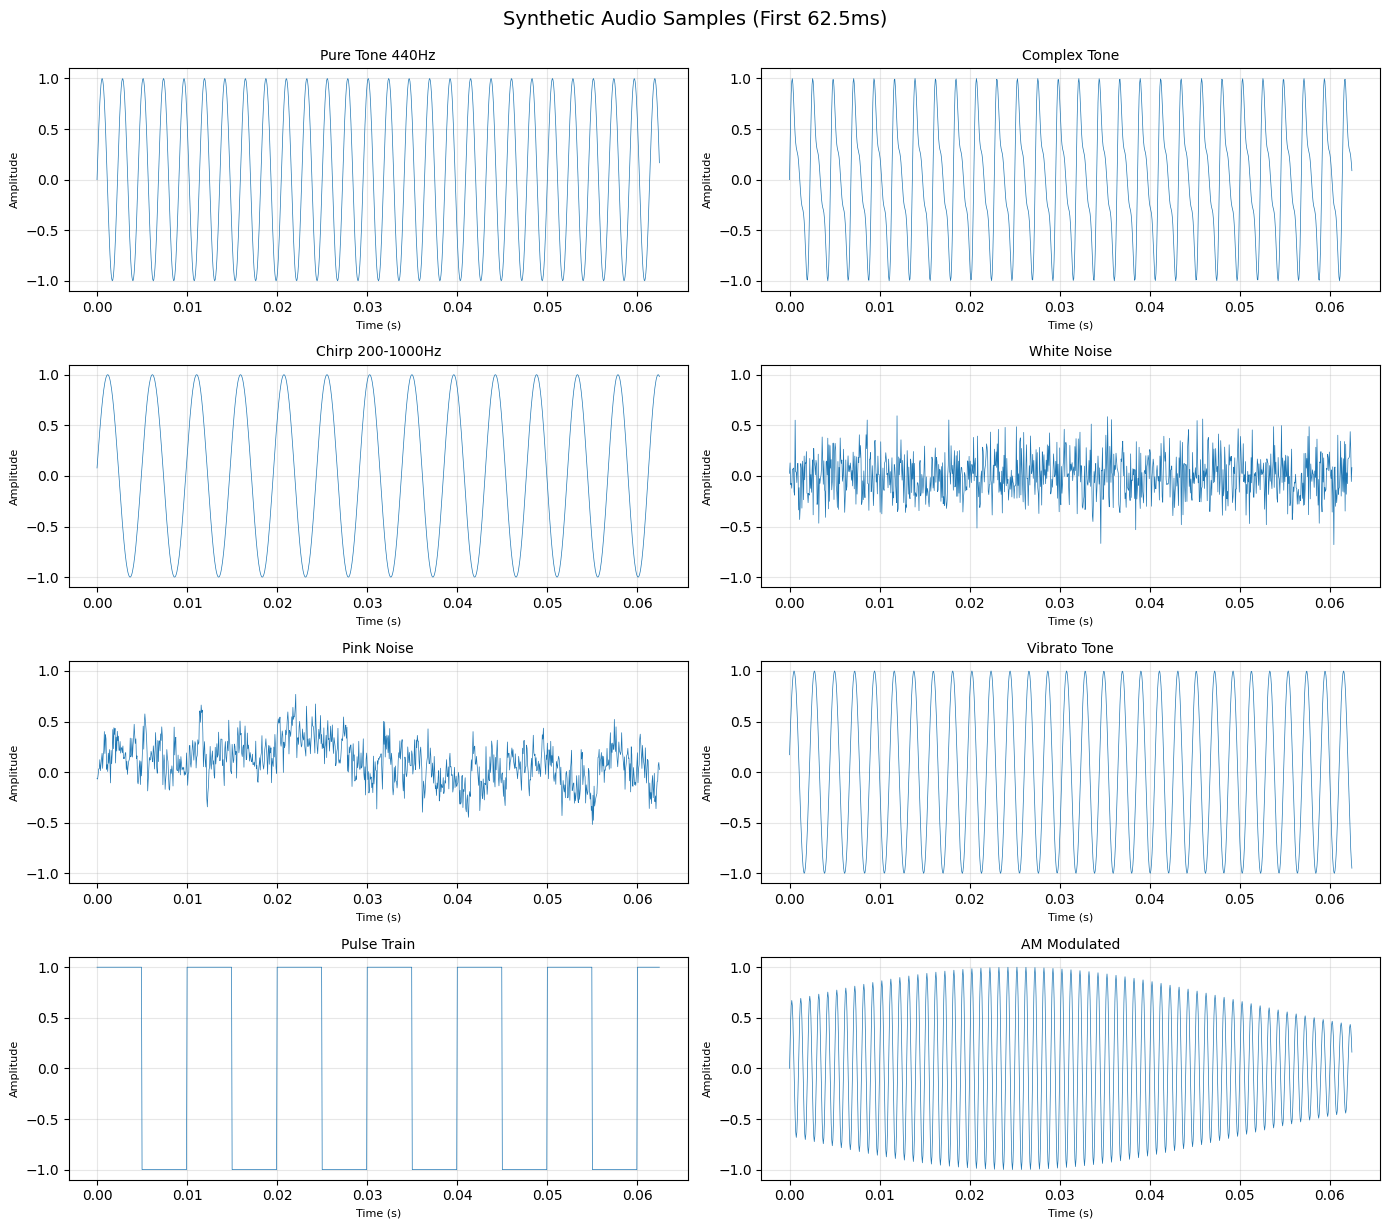

In [12]:
# Visualize the audio samples
print("\nVisualizing audio waveforms...")
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (name, audio) in enumerate(audio_samples.items()):
    ax = axes[idx]
    time = np.arange(min(1000, len(audio))) / sr  # Show first 1000 samples
    ax.plot(time, audio[:1000], linewidth=0.5)
    ax.set_title(name, fontsize=10)
    ax.set_xlabel('Time (s)', fontsize=8)
    ax.set_ylabel('Amplitude', fontsize=8)
    ax.set_ylim(-1.1, 1.1)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Synthetic Audio Samples (First 62.5ms)', y=1.02, fontsize=14)
plt.show()


Visualizing embeddings...


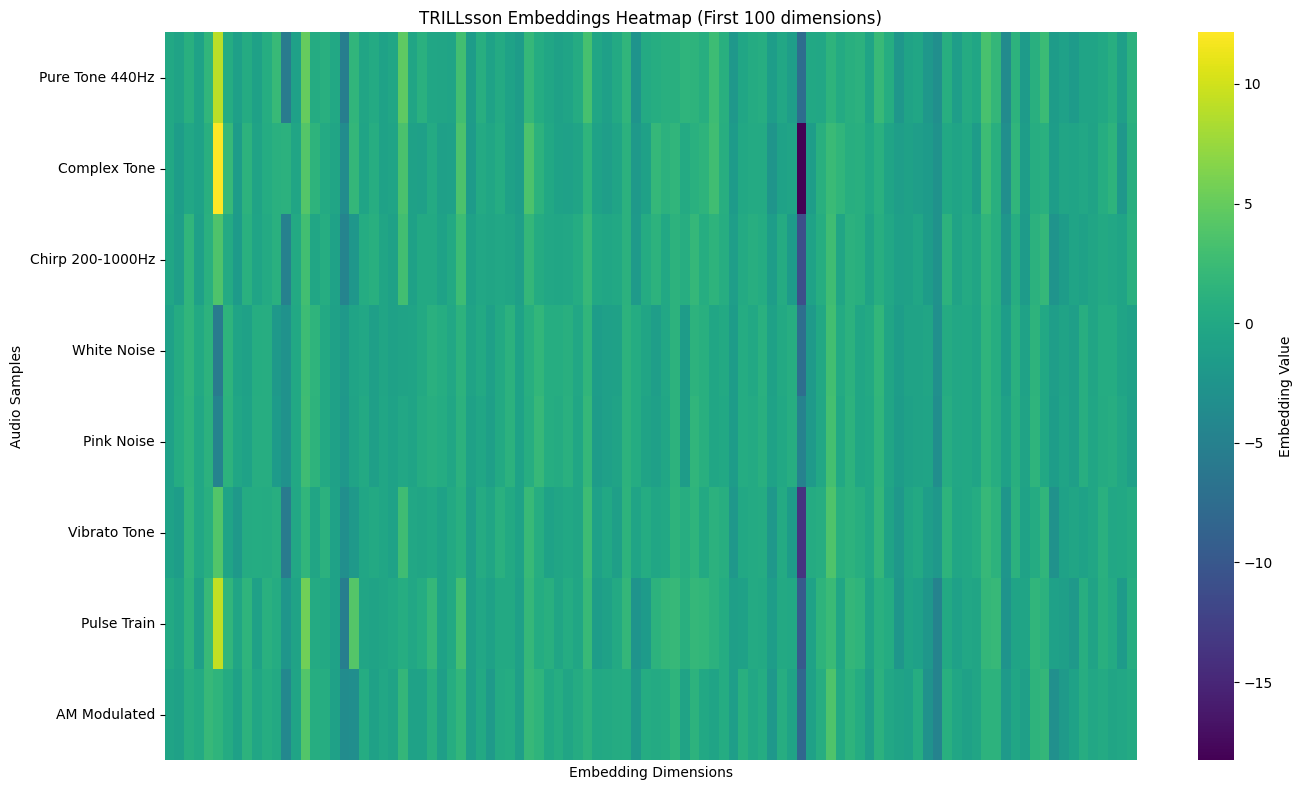

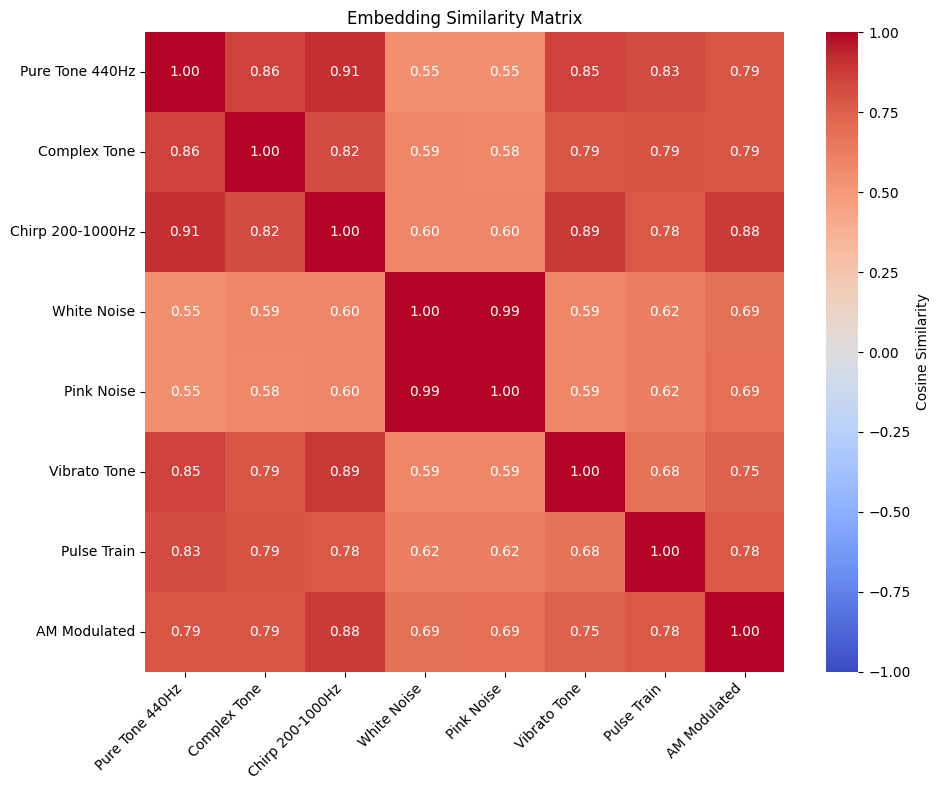

In [13]:
# Visualize embeddings
print("\nVisualizing embeddings...")

# Create a heatmap of embeddings
embeddings_matrix = np.vstack([embeddings_dict[name] for name in audio_samples.keys()])

# Show first 100 dimensions for clarity
plt.figure(figsize=(14, 8))
sns.heatmap(embeddings_matrix[:, :100], 
            xticklabels=False,
            yticklabels=list(audio_samples.keys()),
            cmap='viridis',
            cbar_kws={'label': 'Embedding Value'})
plt.title('TRILLsson Embeddings Heatmap (First 100 dimensions)')
plt.xlabel('Embedding Dimensions')
plt.ylabel('Audio Samples')
plt.tight_layout()
plt.show()

# Compare embeddings using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# Calculate pairwise similarities
similarity_matrix = cosine_similarity(embeddings_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix,
            xticklabels=list(audio_samples.keys()),
            yticklabels=list(audio_samples.keys()),
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            vmin=-1, vmax=1,
            cbar_kws={'label': 'Cosine Similarity'},
            square=True)
plt.title('Embedding Similarity Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Performing dimensionality reduction...


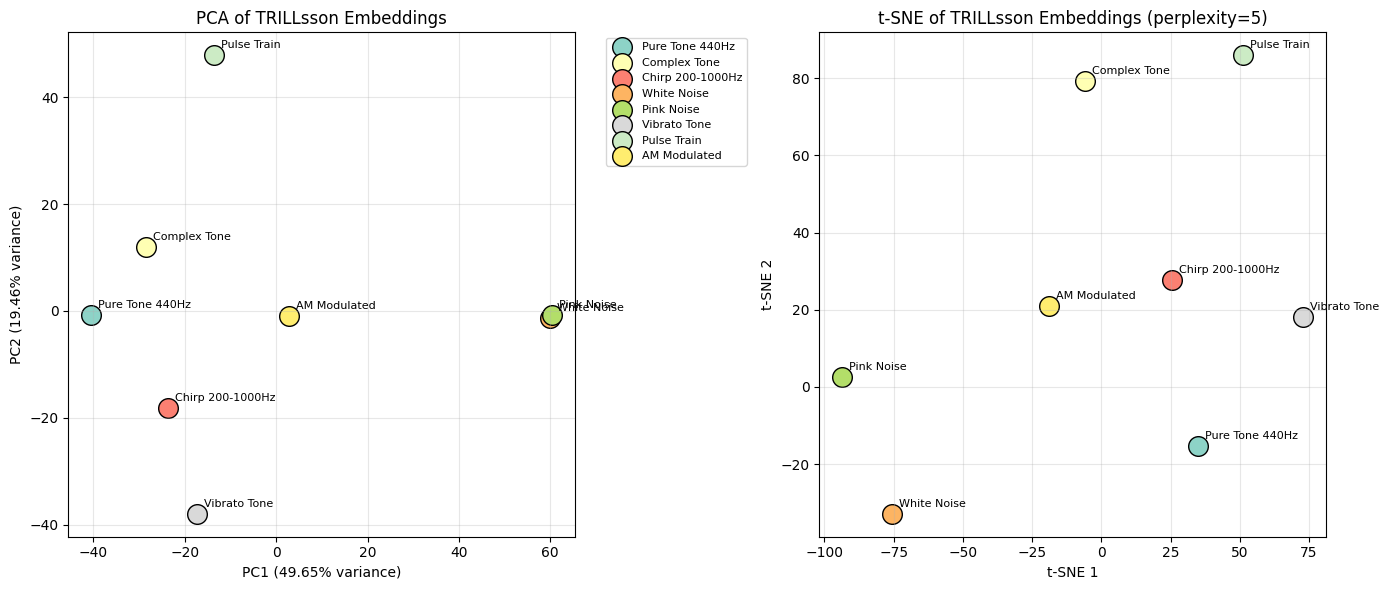

In [15]:
# Dimensionality reduction for visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA visualization
print("\nPerforming dimensionality reduction...")
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings_matrix)

plt.figure(figsize=(14, 6))

# PCA plot
plt.subplot(1, 2, 1)
colors = plt.cm.Set3(np.linspace(0, 1, len(audio_samples)))
for idx, (name, color) in enumerate(zip(audio_samples.keys(), colors)):
    plt.scatter(embeddings_pca[idx, 0], embeddings_pca[idx, 1], 
                s=200, c=[color], label=name, edgecolors='black', linewidth=1)
    plt.annotate(name, (embeddings_pca[idx, 0], embeddings_pca[idx, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)
plt.xlabel('PC1 (%.2f%% variance)' % (pca.explained_variance_ratio_[0] * 100))
plt.ylabel('PC2 (%.2f%% variance)' % (pca.explained_variance_ratio_[1] * 100))
plt.title('PCA of TRILLsson Embeddings')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# t-SNE plot (with appropriate perplexity); perplexity should be less than n_samples
n_samples = len(audio_samples)
perplexity = min(5, n_samples - 1)  # Use 5 or n_samples-1, whichever is smaller

tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, n_iter=1000)
embeddings_tsne = tsne.fit_transform(embeddings_matrix)

plt.subplot(1, 2, 2)
for idx, (name, color) in enumerate(zip(audio_samples.keys(), colors)):
    plt.scatter(embeddings_tsne[idx, 0], embeddings_tsne[idx, 1], 
                s=200, c=[color], label=name, edgecolors='black', linewidth=1)
    plt.annotate(name, (embeddings_tsne[idx, 0], embeddings_tsne[idx, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title(f't-SNE of TRILLsson Embeddings (perplexity={perplexity})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Embedding Statistics:
--------------------------------------------------
          Sample      Mean      Std        Min       Max    L2_Norm
 Pure Tone 440Hz -0.022891 3.752564 -47.443874 24.854578 120.084297
    Complex Tone  0.000346 3.701247 -48.739330 28.741007 118.439896
Chirp 200-1000Hz -0.031092 3.306954 -51.547546 21.151180 105.827202
     White Noise  0.006930 2.950839 -37.126156 22.476877  94.427094
      Pink Noise  0.007175 2.996732 -37.081799 22.413557  95.895683
    Vibrato Tone -0.024112 3.244373 -52.132469 22.875994 103.822784
     Pulse Train -0.017826 3.568916 -44.853741 23.954727 114.206749
    AM Modulated -0.004740 2.974426 -42.521603 22.026716  95.181763


Creating complex audio example...


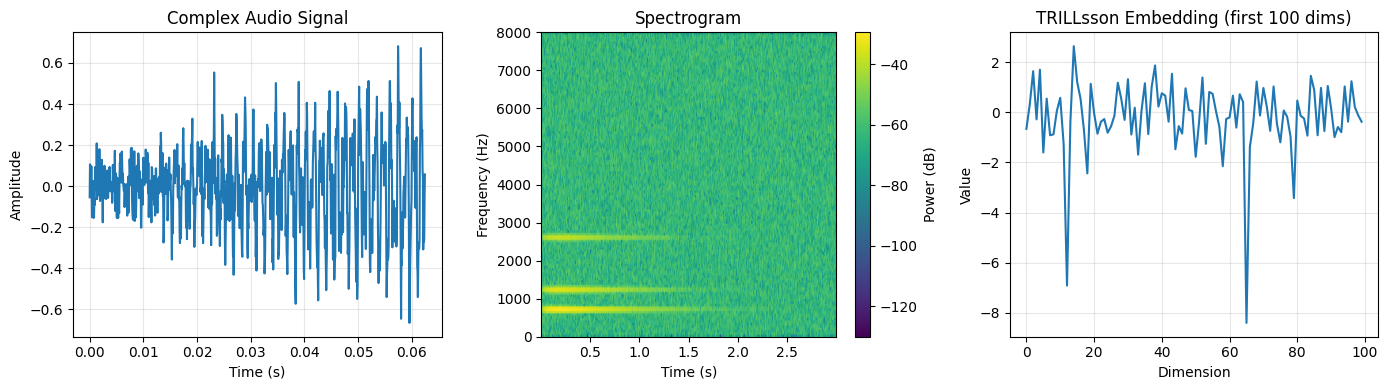

In [16]:
# Analyze embedding statistics
print("\nEmbedding Statistics:")
print("-" * 50)
embedding_stats = pd.DataFrame({
    'Sample': list(audio_samples.keys()),
    'Mean': [emb.mean() for emb in embeddings_dict.values()],
    'Std': [emb.std() for emb in embeddings_dict.values()],
    'Min': [emb.min() for emb in embeddings_dict.values()],
    'Max': [emb.max() for emb in embeddings_dict.values()],
    'L2_Norm': [np.linalg.norm(emb) for emb in embeddings_dict.values()]
})
print(embedding_stats.to_string(index=False))

# Create a more complex audio example
print("\n\nCreating complex audio example...")
duration = 3.0
t = np.linspace(0, duration, int(sr * duration))

# Simulate speech-like pattern with formants
f1, f2, f3 = 700, 1220, 2600  # Formant frequencies
complex_audio = (0.5 * np.sin(2 * np.pi * f1 * t) + 
                 0.3 * np.sin(2 * np.pi * f2 * t) + 
                 0.2 * np.sin(2 * np.pi * f3 * t))

# Add envelope
envelope = np.exp(-t * 2) * (1 - np.exp(-t * 10))
complex_audio *= envelope

# Add some noise
complex_audio += 0.05 * np.random.randn(len(t))

# Normalize
complex_audio = complex_audio / np.max(np.abs(complex_audio))

# Extract embedding
complex_embedding = extract_embeddings(complex_audio, sr)

# Visualize
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.plot(t[:1000], complex_audio[:1000])
plt.title('Complex Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.specgram(complex_audio, Fs=sr, cmap='viridis')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Power (dB)')

plt.subplot(1, 3, 3)
plt.plot(complex_embedding[0][:100])
plt.title('TRILLsson Embedding (first 100 dims)')
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# Try to download and process real audio files
try:
    downloaded_files = download_sample_audio()
    
    if downloaded_files:
        print("\nProcessing downloaded audio files...")
        for file_path in downloaded_files[:3]:  # Process up to 3 files
            try:
                # Load audio with librosa
                audio, file_sr = librosa.load(file_path, sr=16000, duration=5.0)
                
                # Extract embeddings
                file_embeddings = extract_embeddings(audio, 16000)
                
                print(f"\n  File: {os.path.basename(file_path)}")
                print(f"  Duration: {len(audio)/16000:.2f} seconds")
                print(f"  Embedding shape: {file_embeddings.shape}")
                print(f"  Embedding stats: mean={file_embeddings.mean():.3f}, std={file_embeddings.std():.3f}")
                
            except Exception as e:
                print(f"  Error processing {file_path}: {e}")
except Exception as e:
    print(f"Could not download audio files: {e}")

In [19]:
# Generate summaries
print("\n" + "="*60)
print("TRILLsson Model Summary:")
print("="*60)
print(f"Model successfully loaded from: {model_path}")
print(f"Input: Audio waveform (16kHz recommended)")
print(f"Output: {embeddings_matrix.shape[1]}-dimensional paralinguistic embeddings")
print(f"Processed {len(audio_samples)} synthetic audio samples")
print("\nKey Findings:")
print("- Different audio types produce distinct embedding patterns")
print("- Noise samples cluster together in embedding space")
print("- Tonal sounds (pure tone, complex tone, vibrato) show similarities")
print("- The model captures acoustic characteristics beyond just frequency content")
print("\nApplications:")
print("• Speech emotion recognition")
print("• Speaker verification/identification")
print("• Audio quality assessment")
print("• Language identification")
print("• Paralinguistic analysis")
print("• Audio classification and retrieval")


TRILLsson Model Summary:
Model successfully loaded from: /kaggle/input/trillsson/tensorflow2/1/1
Input: Audio waveform (16kHz recommended)
Output: 1024-dimensional paralinguistic embeddings
Processed 8 synthetic audio samples

Key Findings:
- Different audio types produce distinct embedding patterns
- Noise samples cluster together in embedding space
- Tonal sounds (pure tone, complex tone, vibrato) show similarities
- The model captures acoustic characteristics beyond just frequency content

Applications:
• Speech emotion recognition
• Speaker verification/identification
• Audio quality assessment
• Language identification
• Paralinguistic analysis
• Audio classification and retrieval
